## Thermally driven Convection -pt 2  

Analysis of the convection run, and more advanced behaviour

**New concepts:** Advection-diffusion solver template, thermal boundary conditions, Rayleigh number, analysis functions, interpolation

**NOTE:** I saved all the python setup of the previous notebook in a file so we don't need to type it again. We just do this:


In [1]:
%run "058-RayleighBenardConvection-setup.py"


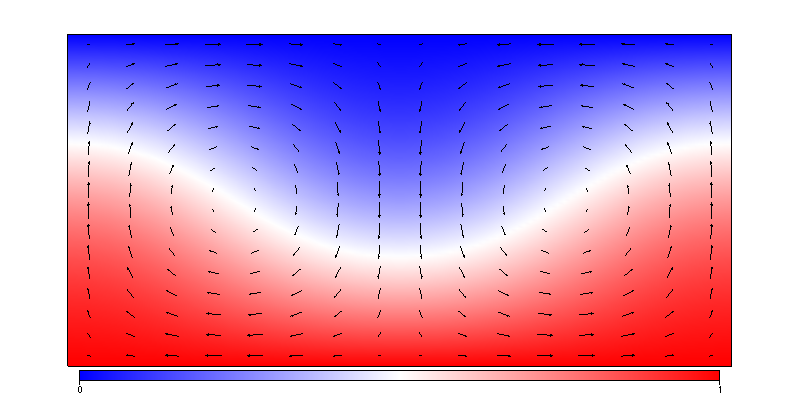

10000.0


In [2]:
# Ready ?

solver.solve()

# plot figure 

figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.1) )
figtemp.show()

print Ra

# (YES !)

## Functions

Underworld defines a special class of parallel-safe, _lazy_ functions. These are used by the finite element routines to build viscosity, buoyancy etc at all the sample points in the domain. They are only evaluated when needed (hence *lazy*) and it is the **definition** which we store, not the values. This is important ... 

The buoyancy function is a uw vector function, so is the temperature (why ?):

``` python
# Rayleigh number.
Ra = 1.0e4

# Construct a density function.
densityFn = Ra * temperatureField

# Define our vertical (upward) unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

```

Watch this:

In [3]:
## Buoyancy Function and lazy evaluation


location = (1.0,0.0)

print Ra
print buoyancyFn.evaluate(location)
print temperatureField.evaluate(location)


Ra = 1.0e8

print Ra
print buoyancyFn.evaluate(location)
print temperatureField.evaluate(location)

10000.0
[[     0.  10000.]]
[[ 1.]]
100000000.0
[[     0.  10000.]]
[[ 1.]]


An alternative way to do this is to use the `constant` function which is more like a parameter-setting function.

In [4]:
# Rayleigh number.
Ra = fn.misc.constant(1.0e4)

# Construct a density function.
densityFn = Ra * temperatureField

# Define our vertical (upward) unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

print buoyancyFn.evaluate(location)
print temperatureField.evaluate(location)

Ra.value = 1.0e8

print buoyancyFn.evaluate(location)
print temperatureField.evaluate(location)

[[     0.  10000.]]
[[ 1.]]
[[  0.00000000e+00   1.00000000e+08]]
[[ 1.]]


This saves us from having to rebuild the buoyancy force term and re-load it into the template every time we need to change the Rayleigh number. 

**NOTE:** if we want to use this now, we have to reload it into the template !!

In [5]:
stokes.fn_bodyforce = buoyancyFn

We can see if that worked ... 

In [6]:
time = 0.
step = 0
steps_end = 200

while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    step += 1

**Plot final temperature and velocity field**


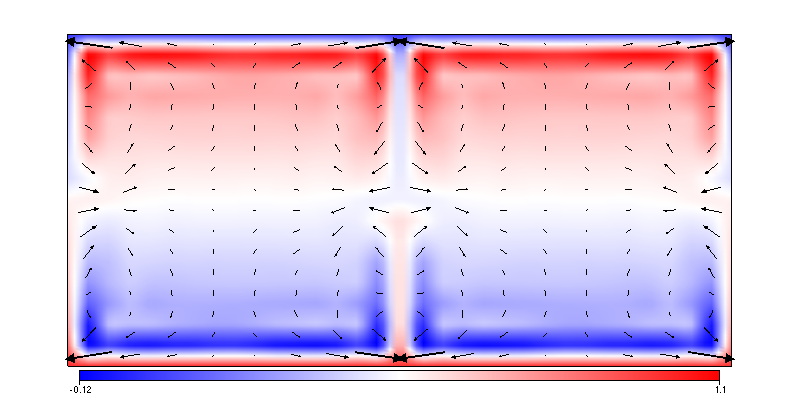

In [7]:
# plot figure
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.001) )
figtemp.show()

## Fields are actually functions

They are not just arrays of values, they also know how they are interpolated / integrated (as proper Finite Element field should).

They can be evaluated everywhere (which is how the plot above is computed, including the vector field)

They can (usually) be differentiated too.

**Watch this !!** 




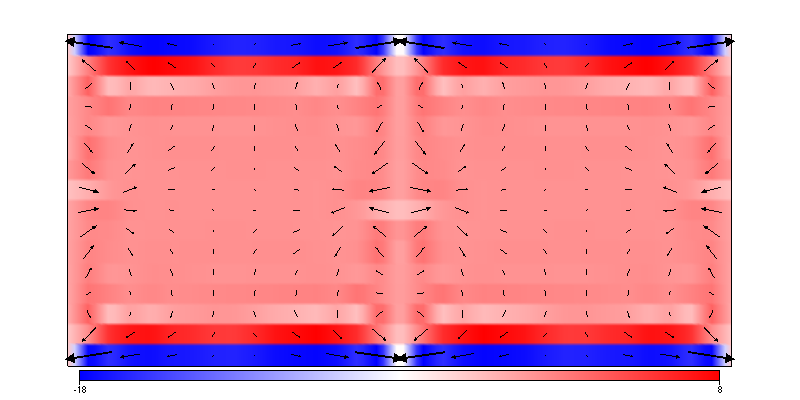

In [8]:
##Vertical temperature gradient

figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField.fn_gradient[1], colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.001) )
figtemp.show()

For more information, look at the underworld user guide !

Let's analyse this solution.  Because the code will usually run in parallel, we need to use the built in tools of `underworld` which know how to compute across multiple processors. 

These are also written as **functions** ( `underworld.function` or `uw.fn` in this notebook).


In [9]:
# Global max min

print fn.view.min_max(temperatureField)

# This is a function that will return the global max / min of the function's last evaluation
# THIS HAS to be done in two steps: evaluate, then ask for max / min

T_maxmin_fn = fn.view.min_max(temperatureField)
T_maxmin_fn.evaluate(mesh)

print T_maxmin_fn.min_global(), T_maxmin_fn.max_global()


-0.165603121233 1.16552239738


**Nusselt number**

The Nusselt number is the ratio between convective and conductive heat transfer. In the R-B convection example, that means 

\\[
Nu = -h \frac{ \int_0^l \partial_z T (x, z=h) dx}{ \int_0^l T (x, z=0) dx}
\\]


In [10]:
nuNumerator    = uw.utils.Integral( fn=temperatureField.fn_gradient[1], 
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

nuDenominator  = uw.utils.Integral( fn=temperatureField,               
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

Nusselt = -1.0 * nuNumerator.evaluate()[0] / nuDenominator.evaluate()[0]

print Nusselt

16.3027915876


The root mean squared velocity is defined by integrating over the entire simulation domain via

\\[
\begin{aligned}
v_{rms}  =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}
\\]

where $dV$ denotes an elemental volume (area) of the box.



In [11]:
int_vdotv_dV = uw.utils.Integral( fn.math.dot( velocityField, velocityField ), mesh )
int_1_dV     = uw.utils.Integral( 1.0 , mesh )

Vrms = int_vdotv_dV.evaluate()[0] / int_1_dV.evaluate()[0]

print "Volume (Area) of the mesh = ", int_1_dV.evaluate()[0]
print "Vrms = ", Vrms

Volume (Area) of the mesh =  2.0
Vrms =  42879998.7522


## Exercise (take away)

Compute the Nusselt / Vrms values for different Rayleigh numbers. 

You may want to do this:

   1. Keep a running log of Nu and Vrms as a function of time 
   2. Use low Ra results as a starting point for higher Ra
   3. Interpolate to finer grids if the computation is not resolved ( * )
    
( * ) Not resolved ?  Maybe the max or min temperature is out of range, maybe the solution does not look physically 'right', maybe the boundary layer is the same thickness as the mesh resolution.

How do I do the interpolation ?

You might be able to just interpolate the T field to a new mesh and continue to solve the velocity and pressure on a coarse mesh -

   1. The velocity field is a lot smoother than the temperature even at high Ra
   2. The code will not mind in serial and might be ok in parallel (if you choose integer 
      multiples for resolution).